In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import warnings as wrn
import umap
import matplotlib.pyplot as plt
# import scnet as scn

wrn.filterwarnings("ignore")

import pooch
import os

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(facecolor = "white", dpi=80)

In [52]:
data_dir = "/samurlab1/Joshua/h5ad/"
file_names = ["AMO1-control.h5ad", "AMO1_EXO1_OE.h5ad", "AMO1_CAD1_KD.h5ad","AMO1_CAD1_KD_EXO1_OE.h5ad"]

adatas = [sc.read(os.path.join(data_dir, fname)) for fname in file_names]

# Merge using scanpy's pipeline-compatible concatenate
adata_merged = adatas[0].concatenate(
    *adatas[1:],
    batch_key="sample",  
    batch_categories=[f.replace(".h5ad", "") for f in file_names],  # label batches by sample
    index_unique="-",  
    join="outer" 
)


In [53]:
adata_merged

AnnData object with n_obs × n_vars = 39528 × 28061
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'ident', 'sample'
    var: 'name-AMO1-control', 'name-AMO1_CAD1_KD', 'name-AMO1_CAD1_KD_EXO1_OE', 'name-AMO1_EXO1_OE'
    obsm: 'X_pca', 'X_umap'

In [54]:
adata_merged.obs["sample"]

AAACAGCCAACCCTCC-1-AMO1-control                    AMO1-control
AAACAGCCAACTCGCG-1-AMO1-control                    AMO1-control
AAACAGCCAATCCTAG-1-AMO1-control                    AMO1-control
AAACAGCCAATCGCAC-1-AMO1-control                    AMO1-control
AAACAGCCACTTCACT-1-AMO1-control                    AMO1-control
                                                   ...         
TTTGTGTTCGGTAACT-1-AMO1_CAD1_KD_EXO1_OE    AMO1_CAD1_KD_EXO1_OE
TTTGTGTTCGTGCTAG-1-AMO1_CAD1_KD_EXO1_OE    AMO1_CAD1_KD_EXO1_OE
TTTGTTGGTAGTCAAT-1-AMO1_CAD1_KD_EXO1_OE    AMO1_CAD1_KD_EXO1_OE
TTTGTTGGTGATGGCT-1-AMO1_CAD1_KD_EXO1_OE    AMO1_CAD1_KD_EXO1_OE
TTTGTTGGTTCACCCA-1-AMO1_CAD1_KD_EXO1_OE    AMO1_CAD1_KD_EXO1_OE
Name: sample, Length: 39528, dtype: category
Categories (4, object): ['AMO1-control', 'AMO1_EXO1_OE', 'AMO1_CAD1_KD', 'AMO1_CAD1_KD_EXO1_OE']

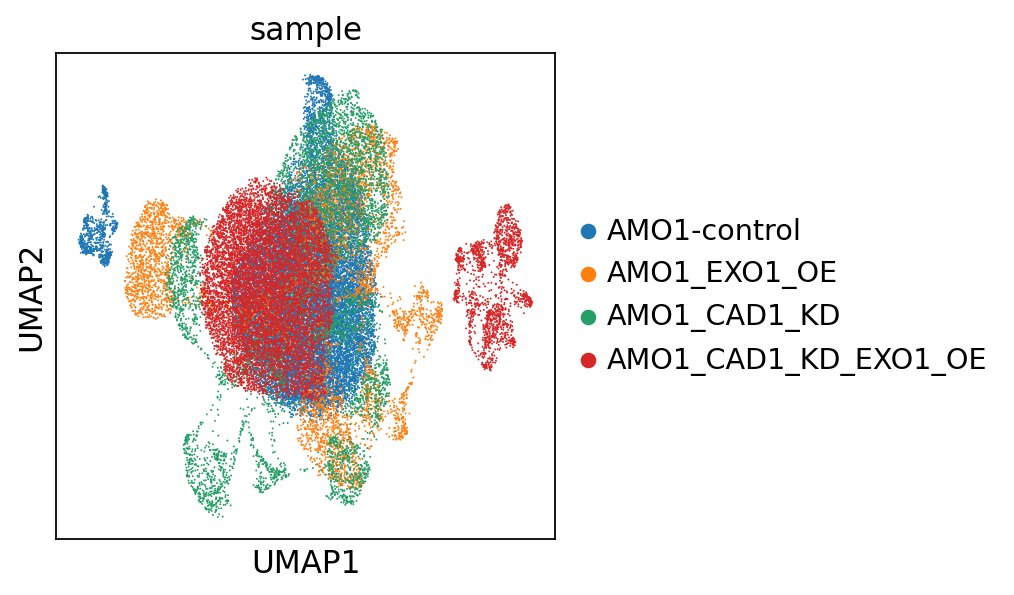

In [55]:
sc.pl.embedding(adata_merged,
                basis='umap',
                color = "sample")

In [57]:
adata_merged.var_names_make_unique()
adata_merged.var

name-AMO1-control name-AMO1_CAD1_KD name-AMO1_CAD1_KD_EXO1_OE  \
A1BG                  A1BG              A1BG                      A1BG   
A1BG-AS1          A1BG-AS1          A1BG-AS1                  A1BG-AS1   
A1CF                   NaN               NaN                       NaN   
A2M                    A2M               A2M                       A2M   
A2M-AS1            A2M-AS1           A2M-AS1                   A2M-AS1   
...                    ...               ...                       ...   
ZYG11A              ZYG11A            ZYG11A                    ZYG11A   
ZYG11B              ZYG11B            ZYG11B                    ZYG11B   
ZYX                    ZYX               ZYX                       ZYX   
ZZEF1                ZZEF1             ZZEF1                     ZZEF1   
ZZZ3                  ZZZ3              ZZZ3                      ZZZ3   

         name-AMO1_EXO1_OE  
A1BG                  A1BG  
A1BG-AS1          A1BG-AS1  
A1CF                  A1CF  
A2M                    A2M  
A2M-AS1            A2M-AS1  
...                    ...  
ZYG11A              ZYG11A  
ZYG11B              ZYG11B  
ZYX                    ZYX  
ZZEF1                ZZEF1  
ZZZ3                  ZZZ3  

[28061 rows x 4 columns]

normalizing counts per cell
    finished (0:00:06)


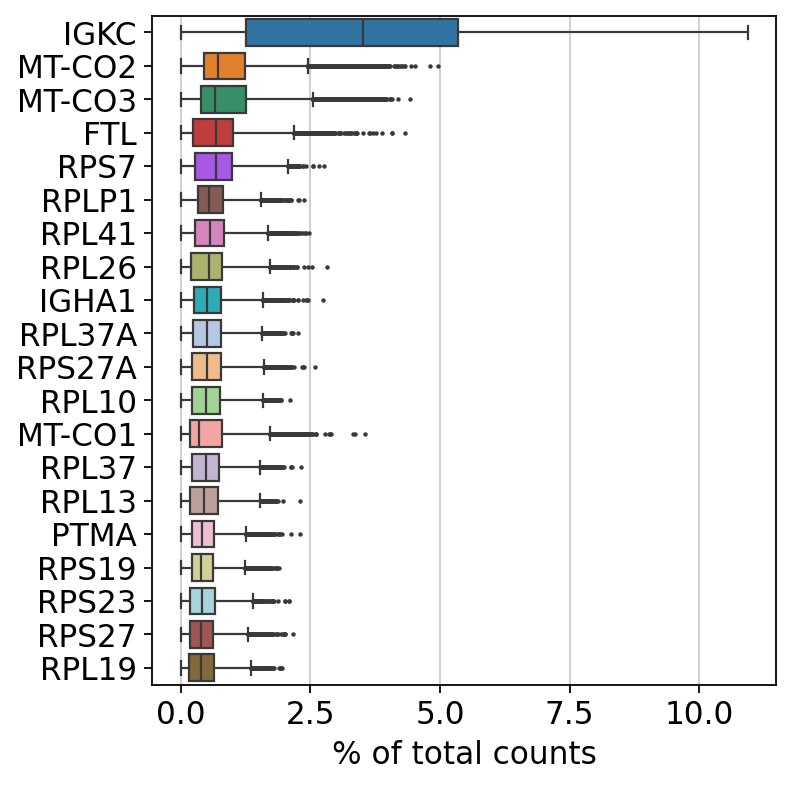

In [58]:
from scipy.sparse import csr_matrix, csc_matrix

# Check if adata.X is sparse (either csr_matrix or csc_matrix) and convert to dense
if isinstance(adata_merged.X, (csr_matrix, csc_matrix)):
    adata_merged.X = adata_merged.X.toarray()  # Convert sparse matrix to dense array
    
sc.pl.highest_expr_genes(adata_merged, n_top=20)

In [59]:
sc.pp.filter_cells(adata_merged, min_genes=100)
sc.pp.filter_genes(adata_merged, min_cells=5)

filtered out 1668 genes that are detected in less than 5 cells


In [60]:
#mitrochondrial genes removal "MT-" for human, "Mt- for mouse"
adata_merged.var["MT"] = adata_merged.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata_merged, qc_vars=["MT"], percent_top=None, log1p=False, inplace=True
)
# ribosomal genes
adata_merged.var["ribo"] = adata_merged.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(
    adata_merged, qc_vars=["ribo"], percent_top=None, log1p=False, inplace=True
)


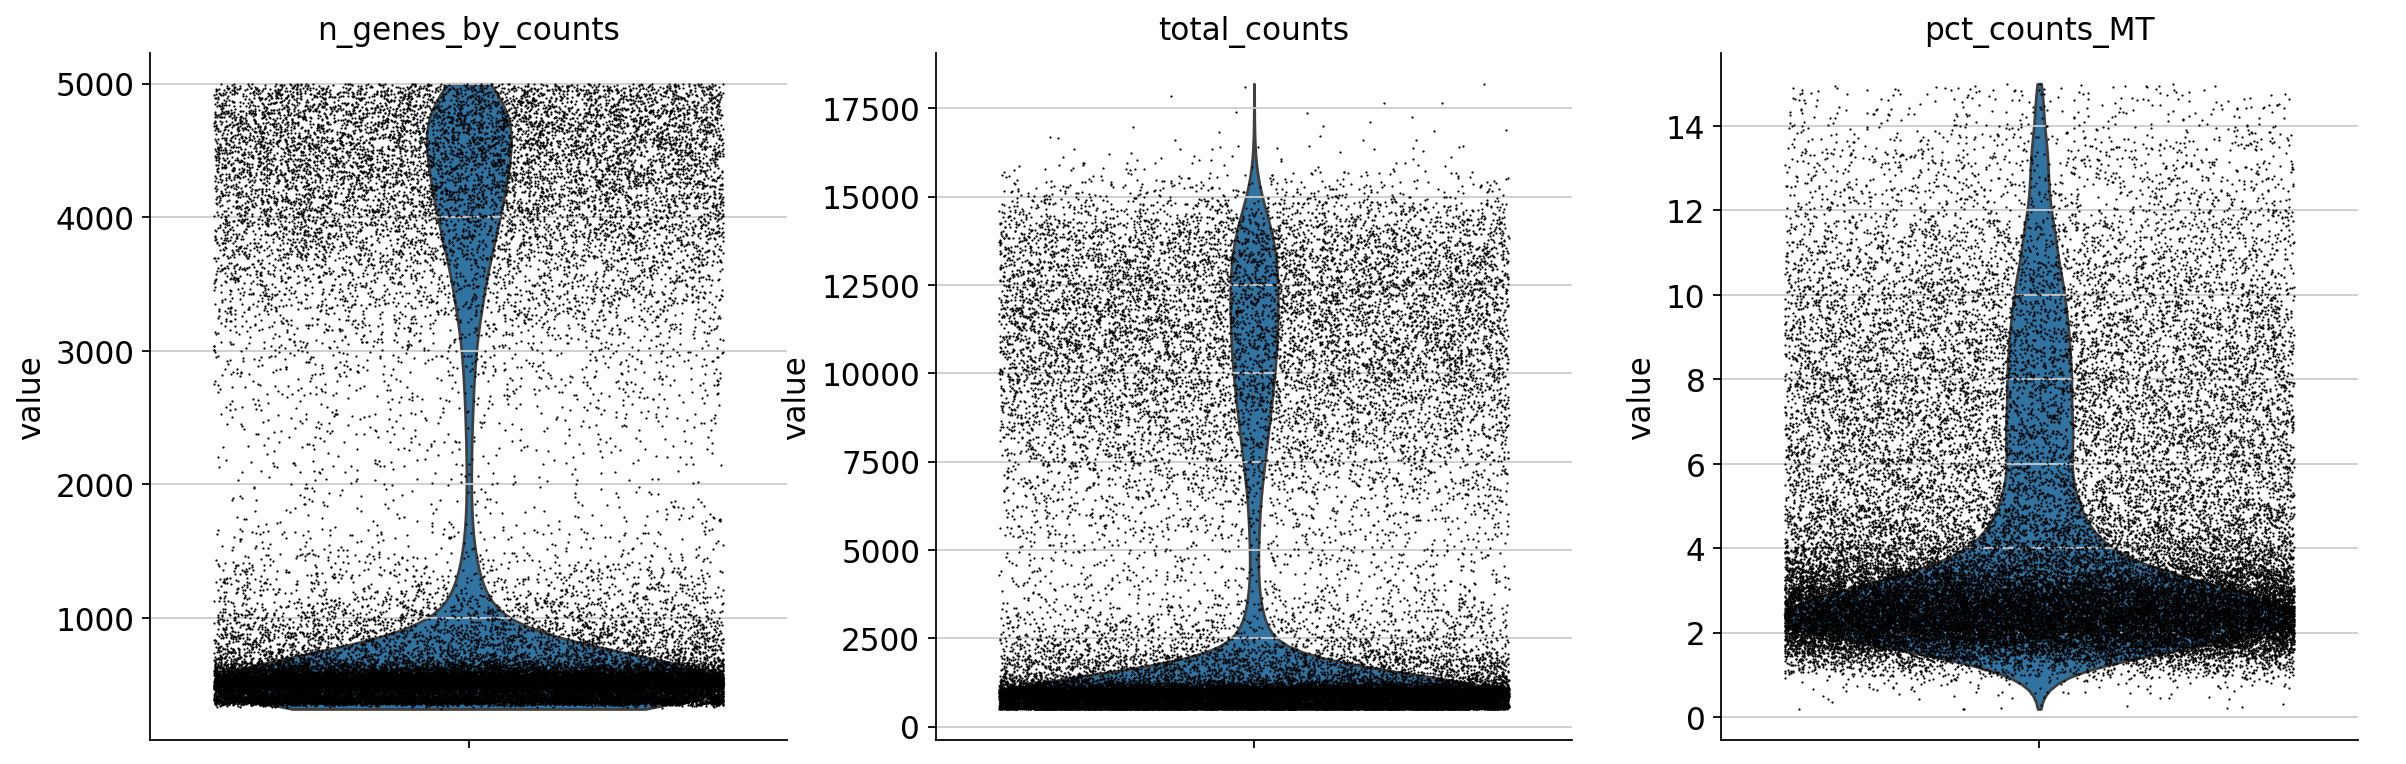

In [61]:
sc.pl.violin(
    adata_merged,
    ["n_genes_by_counts","total_counts","pct_counts_MT"],
    jitter = 0.4,
    multi_panel = True
)

In [62]:
adata_merged.var

name-AMO1-control name-AMO1_CAD1_KD name-AMO1_CAD1_KD_EXO1_OE  \
A1BG                  A1BG              A1BG                      A1BG   
A1BG-AS1          A1BG-AS1          A1BG-AS1                  A1BG-AS1   
A2M                    A2M               A2M                       A2M   
A2M-AS1            A2M-AS1           A2M-AS1                   A2M-AS1   
A2ML1                A2ML1             A2ML1                     A2ML1   
...                    ...               ...                       ...   
ZYG11A              ZYG11A            ZYG11A                    ZYG11A   
ZYG11B              ZYG11B            ZYG11B                    ZYG11B   
ZYX                    ZYX               ZYX                       ZYX   
ZZEF1                ZZEF1             ZZEF1                     ZZEF1   
ZZZ3                  ZZZ3              ZZZ3                      ZZZ3   

         name-AMO1_EXO1_OE  n_cells     MT  n_cells_by_counts  mean_counts  \
A1BG                  A1BG     2967  False               2967     0.080272   
A1BG-AS1          A1BG-AS1     1559  False               1559     0.042046   
A2M                    A2M      179  False                179     0.004554   
A2M-AS1            A2M-AS1       91  False                 91     0.002327   
A2ML1                A2ML1       18  False                 18     0.000506   
...                    ...      ...    ...                ...          ...   
ZYG11A              ZYG11A     6625  False               6625     0.286278   
ZYG11B              ZYG11B     3155  False               3155     0.098664   
ZYX                    ZYX      946  False                946     0.024666   
ZZEF1                ZZEF1     8023  False               8023     0.365538   
ZZZ3                  ZZZ3     9989  False               9989     0.651994   

          pct_dropout_by_counts  total_counts   ribo  
A1BG                  92.493928        3173.0  False  
A1BG-AS1              96.055960        1662.0  False  
A2M                   99.547156         180.0  False  
A2M-AS1               99.769783          92.0  False  
A2ML1                 99.954463          20.0  False  
...                         ...           ...    ...  
ZYG11A                83.239729       11316.0  False  
ZYG11B                92.018316        3900.0  False  
ZYX                   97.606760         975.0  False  
ZZEF1                 79.702995       14449.0  False  
ZZZ3                  74.729306       25772.0  False  

[26393 rows x 11 columns]

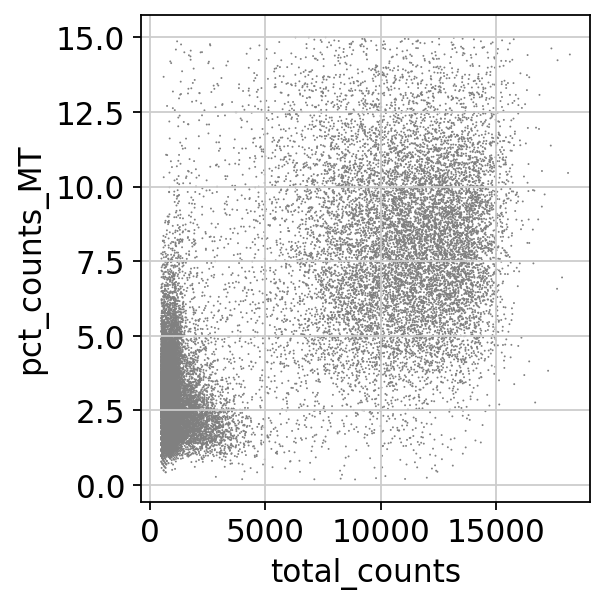

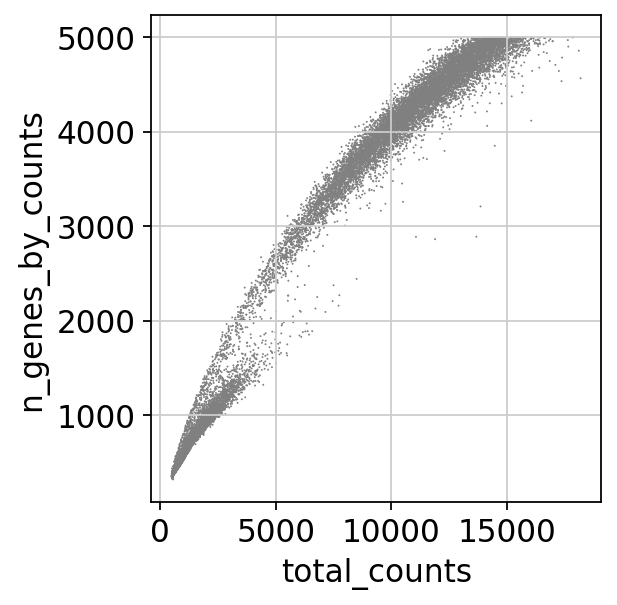

In [63]:
sc.pl.scatter(adata_merged, x="total_counts",y = "pct_counts_MT")
sc.pl.scatter(adata_merged, x ="total_counts",y ="n_genes_by_counts")

In [64]:
adata_merged = adata_merged[adata_merged.obs.n_genes_by_counts < 4500, :]
adata_merged = adata_merged[adata_merged.obs.pct_counts_MT < 10, :].copy()

In [65]:
adata = adata_merged

In [66]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [67]:
sc.pp.highly_variable_genes(adata, batch_key='sample', flavor='seurat_v3', n_top_genes=10000)


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


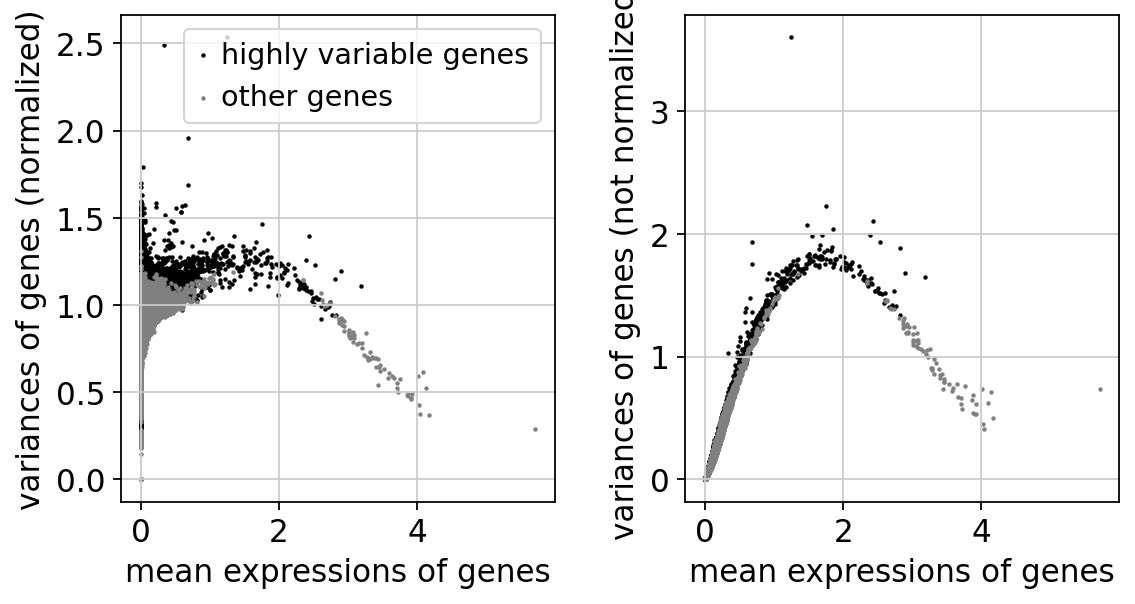

In [68]:
sc.pl.highly_variable_genes(adata)

In [69]:
adata.raw = adata


In [70]:
adata = adata[:, adata.var.highly_variable]


In [71]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_MT"])


regressing out ['total_counts', 'pct_counts_MT']
    finished (0:00:08)


In [73]:
sc.pp.scale(adata, max_value=10)


In [74]:
sc.tl.pca(adata, svd_solver="arpack")


computing PCA
    with n_comps=50
    finished (0:00:53)


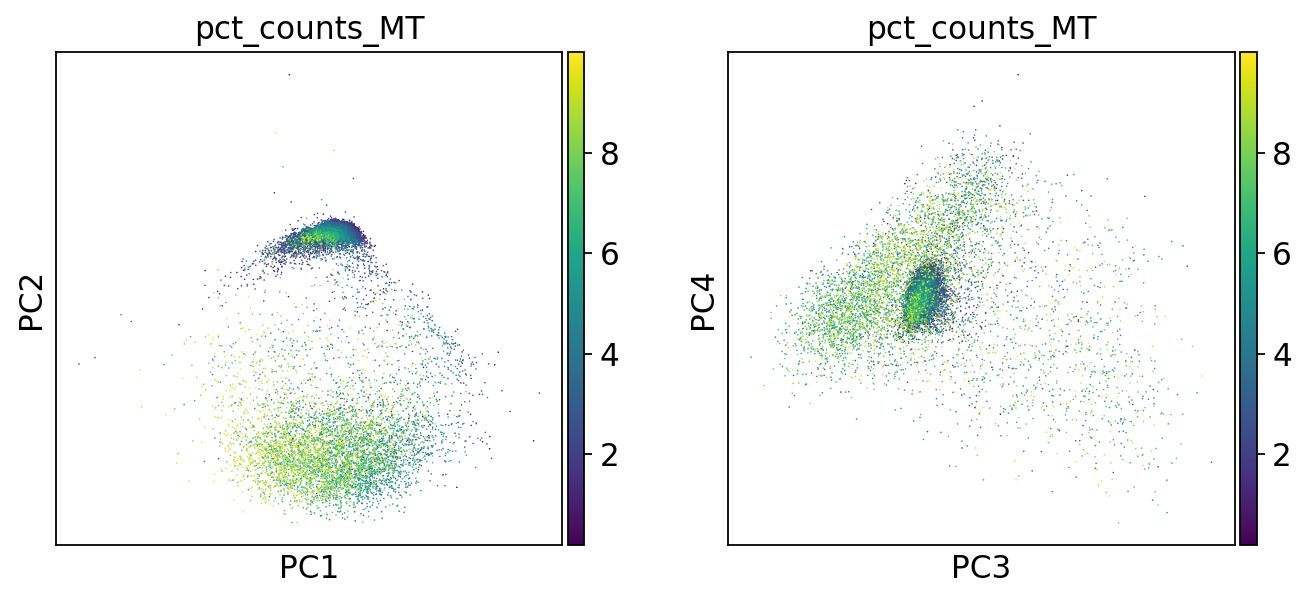

In [75]:
sc.pl.pca(
    adata,
    color = ["pct_counts_MT","pct_counts_MT"],
    dimensions = [(0,1),(2,3)],
    ncols = 2,
    size = 2
)

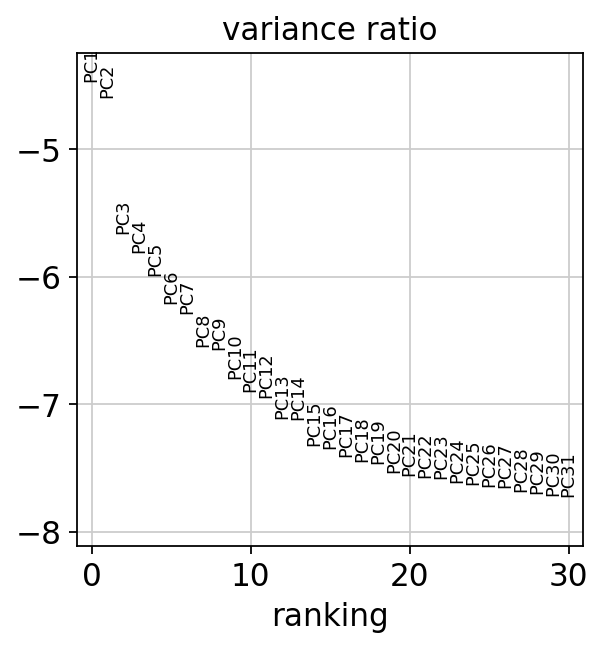

In [76]:
sc.pl.pca_variance_ratio(adata, log=True)


In [77]:
adata.write(filename="/samurlab1/Joshua/h5ad/EXO1_data_scanpy.h5ad")


In [3]:
adata = sc.read(filename="/samurlab1/Joshua/h5ad/EXO1_data_scanpy.h5ad")

In [79]:
adata
# what it should look like 

AnnData object with n_obs × n_vars = 33451 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'ident', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'name-AMO1-control', 'name-AMO1_CAD1_KD', 'name-AMO1_CAD1_KD_EXO1_OE', 'name-AMO1_EXO1_OE', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [4]:
adata

AnnData object with n_obs × n_vars = 33451 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'ident', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'name-AMO1-control', 'name-AMO1_CAD1_KD', 'name-AMO1_CAD1_KD_EXO1_OE', 'name-AMO1_EXO1_OE', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [80]:
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs = 20)


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [81]:
sc.tl.umap(adata)
sc.tl.leiden(
    adata,
    resolution=0.3,
    random_state=0,
    n_iterations=2,
    directed=False,
)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:29)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:35)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:24)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:26)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:40)


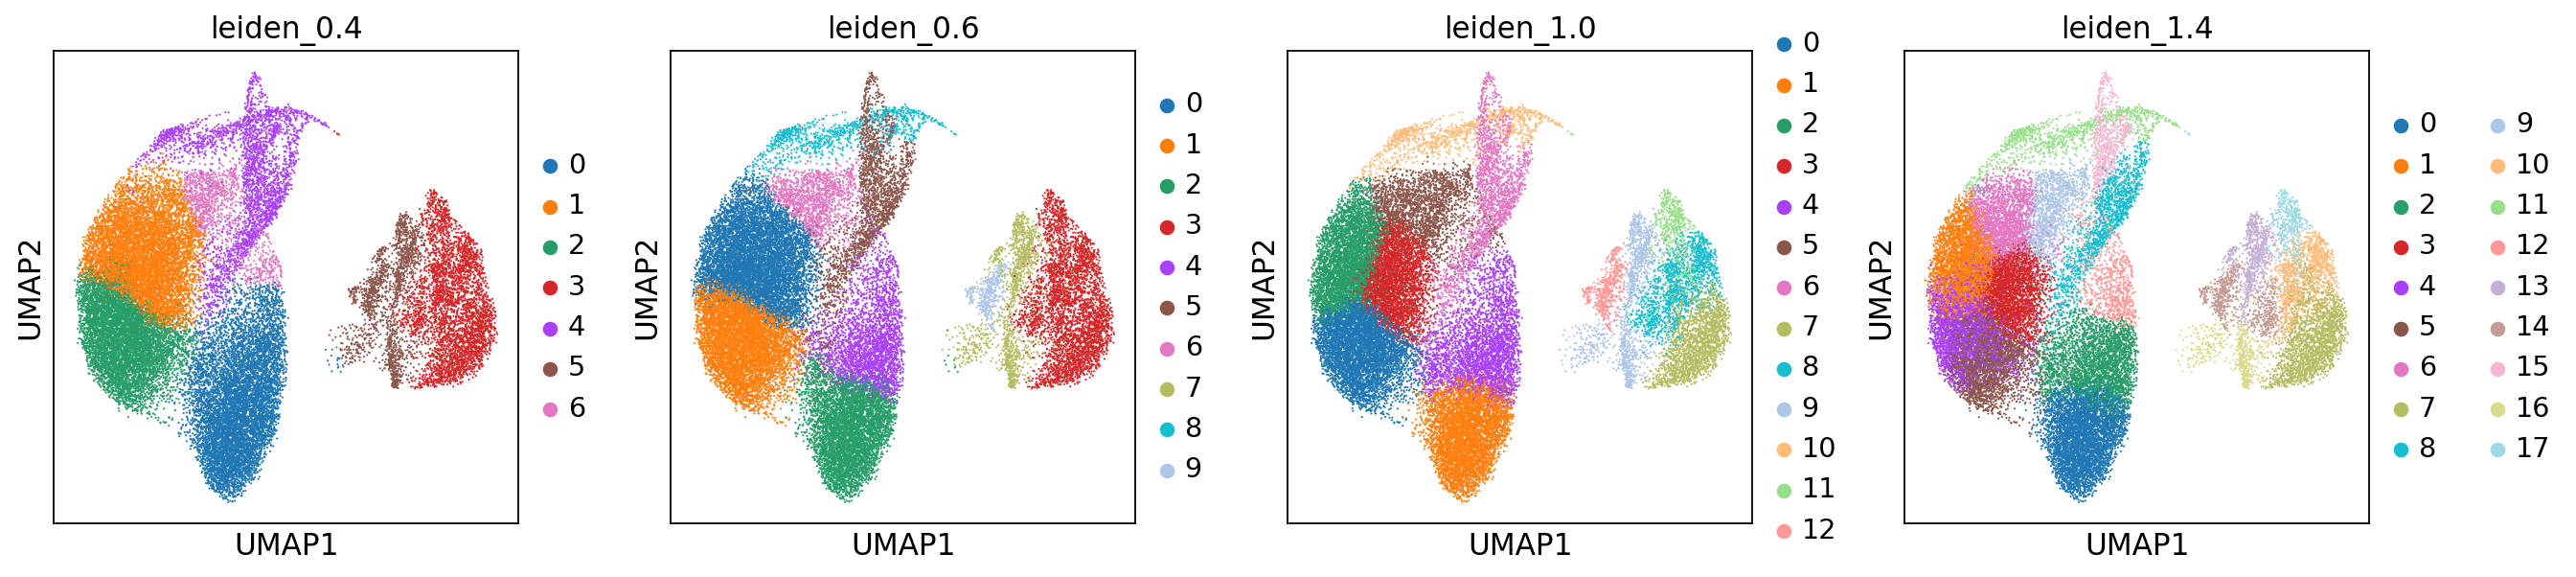

In [82]:
sc.tl.leiden(adata, key_added = "leiden_1.0") # default resolution in 1.0
sc.tl.leiden(adata, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution = 1.4, key_added = "leiden_1.4")

sc.pl.umap(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

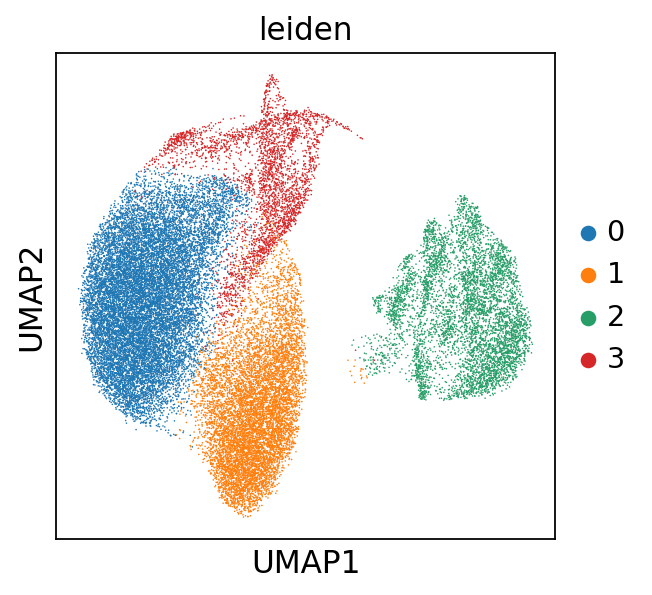

In [83]:
sc.pl.umap(
    adata,
    color=['leiden'],
    size = 2,
    edges = False
)

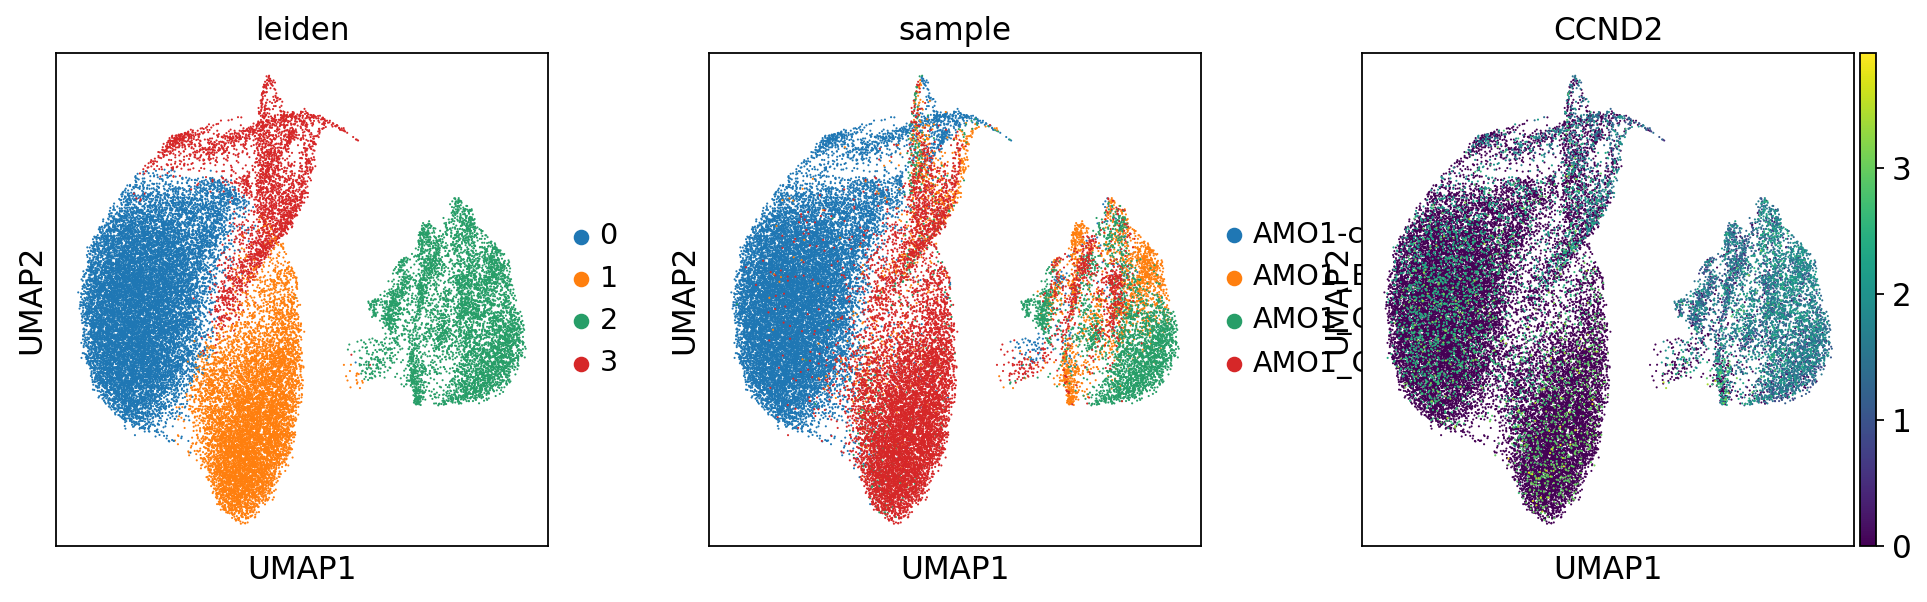

In [85]:
sc.pl.umap(adata,
           color = ["leiden","sample","CCND2"]
    
)

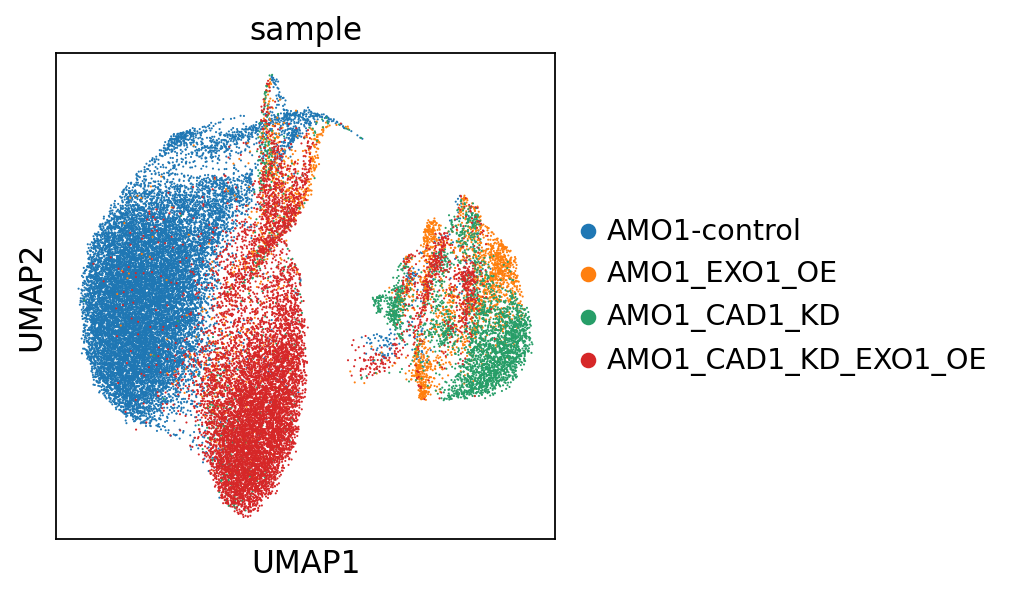

In [86]:
sc.pl.umap(adata,
           color = ["sample"]   
)

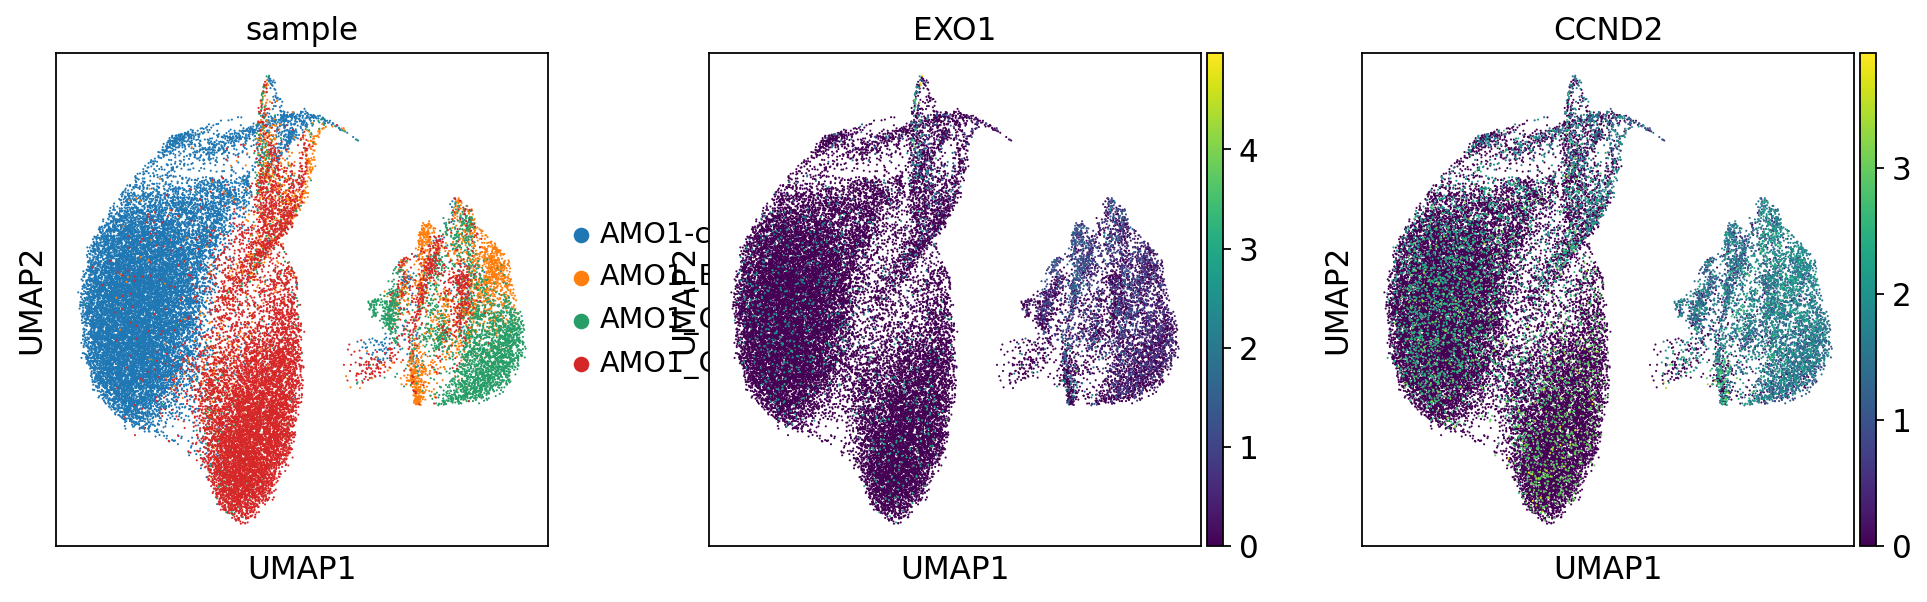

In [87]:
sc.pl.umap(adata,
           color = ["sample","EXO1","CCND2"]
    
)

## I am assuming cluster #2 is the actual AMO1 cells and not contaminant and will perform analysis on those cells. 

I will do all subsequent analysis on these cells. 

In [88]:
adata_cluster2 = adata[adata.obs['leiden'] == '2'].copy()


In [89]:
adata_cluster2.write(filename="/samurlab1/Joshua/h5ad/EXO1_data_minusContaminant_scanpy.h5ad")


In [4]:
adata_cluster2 = sc.read(filename="/samurlab1/Joshua/h5ad/EXO1_data_minusContaminant_scanpy.h5ad")

In [5]:
adata = adata_cluster2

In [91]:
adata
# how it should look

AnnData object with n_obs × n_vars = 5802 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'ident', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4'
    var: 'name-AMO1-control', 'name-AMO1_CAD1_KD', 'name-AMO1_CAD1_KD_EXO1_OE', 'name-AMO1_EXO1_OE', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'sample_colors', 'neighbors', 'umap', 'leiden', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_1.0_colors', 'leiden_1.4_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [6]:
adata
#check data structure

AnnData object with n_obs × n_vars = 5802 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'ident', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4'
    var: 'name-AMO1-control', 'name-AMO1_CAD1_KD', 'name-AMO1_CAD1_KD_EXO1_OE', 'name-AMO1_EXO1_OE', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## 1- What genes and pathways predominantly upregulated in A2 but downregulated in A3, relative to A1. Could you make pathway figure and provide excel sheet with list of genes.

In [7]:
groups = ['AMO1-control', 'AMO1_EXO1_OE', 'AMO1_CAD1_KD']
adata_sub = adata[adata.obs['sample'].isin(groups)].copy()

In [8]:
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='sample', 
    reference='AMO1-control', 
    method='wilcoxon', 
    pts=True
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


# Now I will perform the following analysis:

1. Up in EXO1_OE compared to control

2. Down in CAD1 KD compared to control

3. What genes are specifically up in EXO1_OE compared to CAD1_KD
    
    n = 25 genes

In [9]:
import pandas as pd

#upregulated in EXO1_OE vs control
exo1_up = sc.get.rank_genes_groups_df(adata_sub, group='AMO1_EXO1_OE')
exo1_up = exo1_up.query('logfoldchanges > 1 and pvals_adj < 0.05')

print(exo1_up)

                names     scores  logfoldchanges         pvals     pvals_adj  \
0              MT-ND3  17.337368        1.090655  2.457379e-67  2.161920e-63   
1                SOX5  15.973431        4.204929  1.957200e-57  8.609399e-54   
2     ENSG00000289474  15.756844        1.567509  6.163563e-56  2.323928e-52   
3               STAT1  15.303269        1.955805  7.271040e-53  2.132273e-49   
4               PLCG2  14.589869        1.524376  3.258231e-48  7.166207e-45   
...               ...        ...             ...           ...           ...   
1485           ZNF337   3.000894        2.025789  2.691880e-03  3.806824e-02   
1501  ENSG00000247134   2.980383        1.014247  2.878880e-03  4.035172e-02   
1511          SEC61A2   2.971514        1.029707  2.963359e-03  4.129458e-02   
1524          CCDC134   2.953885        1.230308  3.138010e-03  4.336204e-02   
1538  ENSG00000271533   2.934483        1.458072  3.341044e-03  4.571289e-02   

      pct_nz_group  
0         0.994339

In [10]:
exo1_up.to_csv("/homes6/joshua/EXO1_data/exo1_up_vs_control.txt", sep="\t", index=False)


In [11]:
#upregulated in CAD1_KD vs control
cad1_down = sc.get.rank_genes_groups_df(adata_sub, group='AMO1_CAD1_KD')
cad1_down = cad1_down.query('logfoldchanges > 1 and pvals_adj < 0.05')

print(cad1_down)

                 names     scores  logfoldchanges          pvals  \
98              MT-ND3  11.359531        0.619868   6.650072e-30   
143    ENSG00000289901  10.509851        0.944086   7.781618e-26   
145             MT-CO3  10.442996        0.505838   1.577513e-25   
163               MDM2  10.147437        0.954337   3.401788e-24   
192               BPTF   9.650054        0.845260   4.913004e-22   
...                ...        ...             ...            ...   
26388              FTL -19.591047       -1.415972   1.843621e-85   
26389            RPL13 -20.797604       -1.336850   4.549788e-96   
26390           JCHAIN -20.974726       -1.905839   1.116092e-97   
26391             CCL3 -21.820969       -5.970863  1.467184e-105   
26392             IGKC -24.455343       -2.334508  4.415158e-132   

           pvals_adj  pct_nz_group  
98      9.487316e-28      0.997910  
143     8.451861e-24      0.993730  
145     1.685640e-23      1.000000  
163     3.288769e-22      0.991292 

In [13]:
cad1_down.to_csv("/homes6/joshua/EXO1_data/CAD1_KD_up_vs_control.txt", sep = "\t", index = False)

In [14]:
# Genes that are up in EXO1_OE but down in CAD1_KD
exo_up_genes = set(exo1_up['names'])
cad_down_genes = set(cad1_down['names'])

signature_genes = list(exo_up_genes.intersection(cad_down_genes))
print(signature_genes)
len(signature_genes)

['TXK', 'FNDC3B', 'RAD51-AS1', 'ANKRD17-DT', 'MT-ND3', 'KIF3B', 'USP4', 'CTH', 'ENSG00000225218', 'ZNF700', 'MSC-AS1', 'ELOVL5', 'BRD9', 'EXO1', 'MBNL2', 'BCAT1', 'THUMPD3-AS1', 'TOX2', 'NIF3L1', 'PRDM2', 'RFFL', 'ENSG00000289474', 'MGAT3', 'DNAJC16', 'CORIN']


25

# NEW analysis approach

In [14]:
# A2 = EXO1_OE vs control
exo1_df = sc.get.rank_genes_groups_df(adata_sub, group='AMO1_EXO1_OE')

# A3 = CAD1_KD vs control
cad1_df = sc.get.rank_genes_groups_df(adata_sub, group='AMO1_CAD1_KD')


## Question 1 from Masood

 What genes and pathways predominantly upregulated in A2 but downregulated in A3, relative to A1?
 

## EXO1_OE up and down in CAD1_KD 

In [17]:
exo1_up = exo1_df.query('logfoldchanges > 1 and pvals_adj < 0.05')
cad1_down = cad1_df.query('logfoldchanges < 1 and pvals_adj < 0.05')

sig1_genes = sorted(set(exo1_up['names']).intersection(cad1_down['names']))


In [18]:
print(sig1_genes)

['ANKRD17-DT', 'BCAT1', 'BRD9', 'CORIN', 'CTH', 'DNAJC16', 'ELOVL5', 'ENSG00000225218', 'ENSG00000289474', 'EXO1', 'FNDC3B', 'KIF3B', 'MBNL2', 'MGAT3', 'MSC-AS1', 'MT-ND3', 'NIF3L1', 'PRDM2', 'RAD51-AS1', 'RFFL', 'THUMPD3-AS1', 'TOX2', 'TXK', 'USP4', 'ZNF700']


In [19]:
exo1_down = exo1_df.query('logfoldchanges < 1 and pvals_adj < 0.05')
cad1_up = cad1_df.query('logfoldchanges > 1 and pvals_adj < 0.05')

sig2_genes = sorted(set(exo1_down['names']).intersection(cad1_up['names']))


In [20]:
print(sig2_genes)

['AAK1', 'ABCC5', 'ACSS1', 'ADAM22', 'ADAR', 'AEBP2', 'AGFG1', 'ALOX12-AS1', 'ALOX12P2', 'AMBRA1', 'AMZ1', 'ANKRD17', 'ANKRD44', 'AP1AR', 'APLP2', 'ARHGAP10', 'ARHGAP15', 'ARHGAP5', 'ARHGEF11', 'ARHGEF12', 'ARHGEF3', 'ARL15', 'ARL6IP5', 'ARRDC3', 'ATOSA', 'ATP6V1A', 'BASP1', 'BIRC3', 'BMAL1', 'BMPR2', 'BTG1', 'BTG4', 'C2CD5', 'CABIN1', 'CALCRL-AS1', 'CAMK2D', 'CASC20', 'CASC9', 'CASK', 'CCDC91', 'CCSER2', 'CDC73', 'CDH17', 'CDIN1', 'CDKN1B', 'CELF2', 'CEP85L', 'CHMP7', 'CHRM3', 'CHST11', 'CHSY1', 'CLEC2D', 'COL24A1', 'COLCA1', 'COQ10B', 'CRADD', 'CTIF', 'CTSA', 'CYFIP2', 'DCAF6', 'DLEU1', 'DLEU2', 'EIF2AK2', 'ELOVL6', 'ENSG00000222017', 'ENSG00000236449', 'ENSG00000248515', 'ENSG00000249413', 'ENSG00000249743', 'ENSG00000251314', 'ENSG00000251598', 'ENSG00000253642', 'ENSG00000256417', 'ENSG00000258081', 'ENSG00000259692', 'ENSG00000263551', 'ENSG00000267327', 'ENSG00000274265', 'ENSG00000285679', 'ENSG00000287176', 'ENSG00000287352', 'ENSG00000287923', 'ENSG00000288692', 'ENSG00000290